<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/sequencemodels_GloVe_asmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

# tokenize, vectorize and pad before feeding to the pretrained embedding layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-07-19 16:01:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.120.128, 74.125.71.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  41.0MB/s    in 5.6s    

2020-07-19 16:01:26 (41.0 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



# Load data

In [3]:
pd.read_csv("/tmp/training_cleaned.csv").head()
# target 0 is negative, 4 is positive

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
num_sentences = 0
corpus = []

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # Create list items where the first item is the text, found in row[5], and the second is the label.
        # For the labels, change from 0 and 4, to 0 and 1 instead. 
        list_item=[]
        list_item.append(row[5]) # text
        if row[0] == "0":
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
training_size = 160000 # we will just use 160 000 texts for training
test_portion=.1 # i.e. 16000 other texts
sentences=[] # for tokenization fitting
sentences_test=[]
labels = []
labels_test=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])
for x in range(int(training_size*test_portion)):
    sentences_test.append(corpus[training_size+x][0])
    labels_test.append(corpus[training_size+x][1])

In [7]:
sentences[0], len(sentences_test)

('Ugh insomnia and no one is up to keep me company ', 16000)

# Cleaning

In [8]:
# remove urls and @mentions
import re
import string
print(re.sub(r"\S*@\S*", "", "@mention hi"))
print(re.sub(r"\S*@\S*", "", "hi1 hi@gmail.com"))
print(re.sub(r"@\S+", "", "hi1 hi2@gmail.com hi3"))
re.sub(r"http\S+", "", "hello? 1 2 4.   www.google.com https://colab.research.google.com/drive/1kDnJD0twReX_EeRTTxAGzzRG-6Qw_9XH#scrollTo=sYiuevLvayJp")

 hi
hi1 
hi1 hi2 hi3


'hello? 1 2 4.   www.google.com '

In [10]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")
stopword_list.remove("not")
# stopword_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# remove numerics
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [12]:
tokenizer.tokenize("hello? 1 2 4.   www.google.com https://colab.research.google.com/drive/1kDnJD0twReX_EeRTTxAGzzRG-6Qw_9XH#scrollTo=sYiuevLvayJp")

['hello',
 'www',
 'google',
 'com',
 'https',
 'colab',
 'research',
 'google',
 'com',
 'drive',
 'kDnJD',
 'twReX',
 'EeRTTxAGzzRG',
 'Qw',
 'XH',
 'scrollTo',
 'sYiuevLvayJp']

In [13]:
# hence, the overall cleaning function is:

def clean_text(rowtext): # rowtext is a string
    rowtext = re.sub(r"\S*@\S*", "", rowtext)
    rowtext = re.sub(r"http\S+", "",rowtext)
    rowtext = re.sub(r"@\S+", "",rowtext)
    clean_word_list = tokenizer.tokenize(rowtext)
    rowtext = " ".join([word for word in clean_word_list if word not in stopword_list])
    return rowtext

In [14]:
for i,rowtext in enumerate(sentences):
    sentences[i] = rowtext.replace(rowtext, clean_text(rowtext))
for i,rowtext in enumerate(sentences_test):
    sentences_test[i] = rowtext.replace(rowtext, clean_text(rowtext))
sentences[:10]

['Ugh insomnia one keep company',
 'How quot Dreams Creams Disney teams quot',
 'Having glass Malbec going bed',
 'mmm much better day far still quite early last day uds',
 'well thank phone',
 'p n l ke thi',
 'I hate u u dont talk',
 'return spider escaped day woke arm fml im sleeping upstairs tonight',
 'Hell I know nothing css html anything I got websites look professional',
 'last evening braintree home tomorrow ho hum']

# Tokenization and vectorization

In [15]:
oov_tok = "UNK"
max_length = 16
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
sequences_test = tokenizer.texts_to_sequences(sentences_test)
padded = pad_sequences(sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)
padded_test = pad_sequences(sequences_test, padding = padding_type, truncating = trunc_type, maxlen = max_length)

In [16]:
print(sequences[0], vocab_size) # [90, 35, 4968, 2632, 45, 2858] 67494
list(word_index.keys())[list(word_index.values()).index(90)] # thank

[209, 2236, 19, 156, 924] 67803


'thank'

# Import embedding weights

In [17]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-07-19 16:03:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  36.1MB/s    in 9.2s    

2020-07-19 16:03:15 (36.1 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [18]:
embedding_dim = 100
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word); # dict.get(key)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [19]:
embeddings_index["thank"].all() == embeddings_matrix[90].all()

True

In [20]:
embeddings_matrix.shape

(67804, 100)

# Model

In [21]:
from sklearn.model_selection import train_test_split

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=False)),
    tf.keras.layers.Dense(6, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=["accuracy"])
model.summary()

num_epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3)
x_train, x_valid, y_train, y_valid = train_test_split(padded, labels, test_size=0.2, shuffle= True)
history = model.fit(np.array(x_train), np.array(y_train), epochs=num_epochs, callbacks = [callback], validation_data=(np.array(x_valid), np.array(y_valid)), verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           6780400   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                25728     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 6,806,525
Trainable params: 26,125
Non-trainable params: 6,780,400
_________________________________________________________________
Epoch 1/50
4000/4000 - 44s - loss: 0.5358 - accuracy: 0.7258 - val_loss: 0.5021 - val_accuracy: 0.7516
Epoch 2/50
4000/4000 - 43s - loss: 0.4889 - accuracy: 0.7618 - val_loss: 0.4881 - val_accuracy: 0.7617
Epoch 3/50
4000/4000 - 42s - loss

In [24]:
model.evaluate(padded_test, np.array(labels_test))

500/500 [==============================] - 2s 5ms/step - loss: 0.4920 - accuracy: 0.7673


[0.49201956391334534, 0.7673125267028809]

<Figure size 432x288 with 0 Axes>

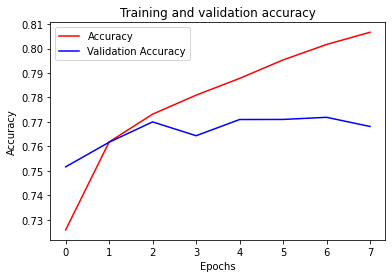

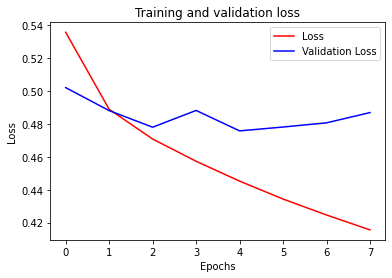

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!